<a href="https://colab.research.google.com/github/KantilalRane/realtime-face-recognition/blob/main/brain_tumor_segmentation_full_dataset_max_epochs1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Brain Tumor Segmentation with U-Net + Hybrid Attention Block
#
# This notebook downloads the BRISC 2025 dataset from Kaggle, extracts it, defines a hybrid attention block (scSE + ECA + CBAM), integrates it into a U-Net model, and sets up data loading and a training scaffold.

# In[1]:


# Step 1: Install kaggle and other dependencies
get_ipython().system('pip install kaggle --quiet')
get_ipython().system('pip install torch torchvision --quiet')
get_ipython().system('pip install nibabel --quiet  # for medical image format handling')


# In[2]:


# Step 2: Download BRISC 2025 Dataset from Kaggle
import os

# Make sure kaggle.json is in ~/.kaggle/kaggle.json
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
# Uncomment and run once if you need to upload your kaggle.json manually
# from google.colab import files
# files.upload()  # Upload kaggle.json
get_ipython().system('mv kaggle.json ~/.kaggle/')
get_ipython().system('chmod 600 ~/.kaggle/kaggle.json')

dataset_path = 'briscdataset/brisc2025'
data_dir = './BRISC2025'

if not os.path.exists(data_dir):
    get_ipython().system('kaggle datasets download -d {dataset_path} --unzip -p {data_dir}')
else:
    print(f"Dataset already downloaded and extracted in {data_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.7 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/briscdataset/brisc2025
License(s): Attribution 4.0 International (CC BY 4.0)
 96% 238M/248M [00:00<00:00, 674MB/s] 
100% 248M/248M [00:00<00:00, 723MB/s]


Epoch 1/20 - Loss: 0.0984 Acc: 0.9715 F1: 0.0029
Epoch 2/20 - Loss: 0.0821 Acc: 0.9743 F1: 0.0000
Epoch 3/20 - Loss: 0.0741 Acc: 0.9763 F1: 0.2214
Epoch 4/20 - Loss: 0.0652 Acc: 0.9795 F1: 0.4311
Epoch 5/20 - Loss: 0.0582 Acc: 0.9814 F1: 0.5115
Epoch 6/20 - Loss: 0.0517 Acc: 0.9829 F1: 0.5717
Epoch 7/20 - Loss: 0.0480 Acc: 0.9838 F1: 0.6029
Epoch 8/20 - Loss: 0.0447 Acc: 0.9846 F1: 0.6316
Epoch 9/20 - Loss: 0.0428 Acc: 0.9853 F1: 0.6520
Epoch 10/20 - Loss: 0.0408 Acc: 0.9858 F1: 0.6689
Epoch 11/20 - Loss: 0.0387 Acc: 0.9864 F1: 0.6861
Epoch 12/20 - Loss: 0.0375 Acc: 0.9868 F1: 0.6990
Epoch 13/20 - Loss: 0.0358 Acc: 0.9872 F1: 0.7105
Epoch 14/20 - Loss: 0.0350 Acc: 0.9874 F1: 0.7186
Epoch 15/20 - Loss: 0.0332 Acc: 0.9880 F1: 0.7336
Epoch 16/20 - Loss: 0.0334 Acc: 0.9879 F1: 0.7318
Epoch 17/20 - Loss: 0.0312 Acc: 0.9886 F1: 0.7502
Epoch 18/20 - Loss: 0.0302 Acc: 0.9889 F1: 0.7588
Epoch 19/20 - Loss: 0.0293 Acc: 0.9892 F1: 0.7661
Epoch 20/20 - Loss: 0.0287 Acc: 0.9894 F1: 0.7730


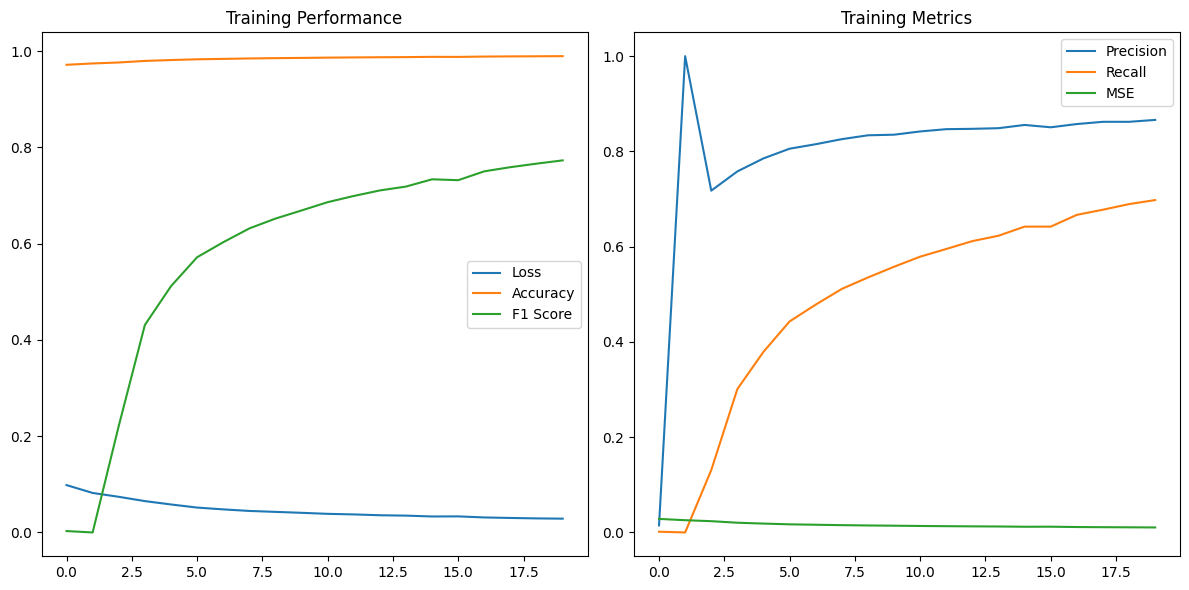

In [2]:
#!/usr/bin/env python
# coding: utf-8




# In[18]:


import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import torch.nn.functional as F

# Step 1: Define Hybrid Attention Block (scSE + ECA + CBAM)
class HybridAttentionBlock(nn.Module):
    def __init__(self, channel, reduction=16, eca_kernel_size=3):
        super(HybridAttentionBlock, self).__init__()
        self.eca_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.eca_conv = nn.Conv1d(1, 1, kernel_size=eca_kernel_size, padding=(eca_kernel_size - 1) // 2, bias=False)
        self.eca_sigmoid = nn.Sigmoid()
        self.channel_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_max_pool = nn.AdaptiveMaxPool2d(1)
        self.channel_fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.channel_sigmoid = nn.Sigmoid()
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.spatial_sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()
        eca_y = self.eca_avg_pool(x).squeeze(-1).transpose(-1, -2)
        eca_y = self.eca_conv(eca_y)
        eca_y = self.eca_sigmoid(eca_y).transpose(-1, -2).unsqueeze(-1)
        avg_pool = self.channel_avg_pool(x)
        max_pool = self.channel_max_pool(x)
        avg_out = self.channel_fc(avg_pool)
        max_out = self.channel_fc(max_pool)
        ch_attn = self.channel_sigmoid(avg_out + max_out)
        channel_attn = eca_y * ch_attn
        x_channel = x * channel_attn.expand_as(x)
        max_result, _ = torch.max(x_channel, dim=1, keepdim=True)
        avg_result = torch.mean(x_channel, dim=1, keepdim=True)
        spatial_input = torch.cat([max_result, avg_result], dim=1)
        spatial_attn = self.spatial_sigmoid(self.spatial_conv(spatial_input))
        out = x_channel * spatial_attn.expand_as(x_channel)
        return out

# Step 2: Define U-Net with Hybrid Attention
class UNetWithHybridAttention(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=64):
        super(UNetWithHybridAttention, self).__init__()
        self.encoder1 = self.conv_block(in_channels, base_channels)
        self.encoder2 = self.conv_block(base_channels, base_channels * 2)
        self.encoder3 = self.conv_block(base_channels * 2, base_channels * 4)
        self.encoder4 = self.conv_block(base_channels * 4, base_channels * 8)
        self.middle = self.conv_block(base_channels * 8, base_channels * 16)
        self.decoder4 = self.deconv_block(base_channels * 16, base_channels * 8)
        self.decoder3 = self.deconv_block(base_channels * 8, base_channels * 4)
        self.decoder2 = self.deconv_block(base_channels * 4, base_channels * 2)
        self.decoder1 = self.deconv_block(base_channels * 2, base_channels)
        self.final_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)
        self.attn1 = HybridAttentionBlock(base_channels)
        self.attn2 = HybridAttentionBlock(base_channels * 2)
        self.attn3 = HybridAttentionBlock(base_channels * 4)
        self.attn4 = HybridAttentionBlock(base_channels * 8)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def deconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, tensor, target_tensor_shape):
        _, _, tensor_h, tensor_w = tensor.size()
        _, _, target_h, target_w = target_tensor_shape

        diff_h = tensor_h - target_h
        diff_w = tensor_w - target_w

        crop_top = diff_h // 2
        crop_left = diff_w // 2

        return tensor[:, :, crop_top:crop_top + target_h, crop_left:crop_left + target_w]

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        middle = self.middle(enc4)
        dec4 = self.attn4(self.decoder4(middle))
        dec3 = self.attn3(self.decoder3(self.center_crop(dec4, enc4.shape) + enc4))
        dec2 = self.attn2(self.decoder2(self.center_crop(dec3, enc3.shape) + enc3))
        dec1 = self.attn1(self.decoder1(self.center_crop(dec2, enc2.shape) + enc2))
        out = self.final_conv(dec1)
        return out

# Step 3: Define Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask) # Apply transform to the mask as well
        mask = (np.array(mask) > 0).astype(np.uint8)
        mask = torch.tensor(mask, dtype=torch.long)
        mask = mask.squeeze(0) # Remove the channel dimension
        return image, mask

# Step 4: Training and Evaluation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = BrainTumorDataset('./BRISC2025/brisc2025/segmentation_task/train/images',
                             './BRISC2025/brisc2025/segmentation_task/train/masks',
                             transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetWithHybridAttention(in_channels=1, out_channels=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
train_loss, train_acc, train_precision, train_recall, train_f1, train_mse = [], [], [], [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss, preds_list, targets_list = 0, [], []
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Resize masks to match the output size of the U-Net
        masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
        targets = masks.cpu().numpy().flatten()
        preds_list.extend(preds)
        targets_list.extend(targets)
    epoch_loss /= len(dataloader)
    train_loss.append(epoch_loss)
    train_acc.append(accuracy_score(targets_list, preds_list))
    train_precision.append(precision_score(targets_list, preds_list))
    train_recall.append(recall_score(targets_list, preds_list))
    train_f1.append(f1_score(targets_list, preds_list))
    train_mse.append(mean_squared_error(targets_list, preds_list))
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {train_acc[-1]:.4f} F1: {train_f1[-1]:.4f}")

# Step 5: Plot Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Loss')
plt.plot(train_acc, label='Accuracy')
plt.plot(train_f1, label='F1 Score')
plt.title('Training Performance')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_precision, label='Precision')
plt.plot(train_recall, label='Recall')
plt.plot(train_mse, label='MSE')
plt.title('Training Metrics')
plt.legend()
plt.tight_layout()
plt.show()